<a href="https://colab.research.google.com/github/bless-god/MODS203/blob/main/invest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Backgroud**

There is a portfolio $Pf$ invested into funds $\{f_1, f_2, \cdots, f_n\}$, with weights on each ticker $\{cw_1, cw_2,\cdots, cw_n\}$. According to some theory, the ideal weight $\{mw_1,mw_2,\cdots,mw_n\}$ will yield the maximum profit.

Now we invest amount $A$ into portfolio $Pf$, and the goal is to spread $A$ across funds $\{f_1, f_2, \cdots, f_n\}$ which makes the updated portfolio $\{nw_1, nw_2, \cdots, nw_n\}$ getting as close to model weight as possible.


## **Problem setup**

Define the current weight under the primary portfolio: $$CW = \{cw_1, cw_2,\cdots, cw_n\}$$, and the ideal model weight is $$MW = \{mw_1,mw_2,\cdots,mw_n\}$$

​After investing $A$, the total funding rises to $Pf+A$, the primary portfolio only counts a proportion of overall funding $\frac{Pf}{Pf+A}$, so the weight is normalized $$CW_{normalized}=\{\frac{cw_1*Pf}{Pf+A}, \frac{cw_2*Pf}{Pf+A},\cdots, \frac{cw_n*Pf}{Pf+A}\}$$


<!-- Ideal weight deduced by economic theory which indicates weight for maximum profit

Topup=10; Fund=90; totalfunding=100, change of weight=10%; 

10 tickers: {1%, 1%, .., 1%} -->

​Change of weight on each ticker due to top up is $\Delta CW = \{\Delta cw_1,\Delta cw_2, \cdots,\Delta cw_n\}$

While $\Sigma (\Delta cw_i) = \frac{A}{Pf+A}$ and $\Delta cw_i \ge 0$.

## **Formulation**

​	The objective function describes the distance between the weight on tickers after top up and the model weight: 
$$f(\Delta CW)=\|MW-(CW_{normalized}+\Delta CW)\|^2$$

Objective function for relative distance:
$$\begin{aligned}
f_2(\Delta CW)&=\log[(MW-(CW_{normalized}+\Delta CW))/MW]^2\\
&=2\Sigma_{i=1}^n [\log(MW_i-CW_{normalized}i-\Delta CW_i)-log(MW_i)]
\end{aligned}$$

<!-- $$d f_2(CW_i)=\frac{1}{CW_i+dw_i-MW_i}$$ -->
​	The goal is to minimize the objective function
​				$$\mathop{\min}_{\Delta CW} f_2(\Delta CW)$$
$$s.t. \Sigma (\Delta cw_i) = \frac{A}{Pf+A}$$

$$\Delta cw_i \ge 0, i\in\{1,\cdots,n\}$$

## **Improvement**
In reality, the investment on every fund has a minimum entry criteria. Which means if you want to invest on one fund, you are supposed to put at least a certain amount of money on it, otherwise you can't top up on it. This property changes the second constraint to
$$\Delta cw_i=0\ or\ \Delta cw_i\ge b_i, i\in\{0,\cdots,n\}$$

Note here $b_i$ is not the minimum topup amount, it corresponds to the weight of the min topup. Mathematically, it's a linear programming problem with disjunctive constraints. The acadamic way to solve this was included in $\textit{Disjunctive programming: Properties of the convex hull of feasible points}$, which was quite complicated. And there is also a library ```pyomo``` able to solve disjunctive programming. Since the library is quite new and full of implementation bugs.

While in practice, the problem is solved by avoding the disjunctive constraints (just taking the constraints in **formulation** part), and manually selecting $\Delta cw_i$ to be $0$ or greater than $b_i$ depending on its distance with $b_i$. In each step of the optimization, we will have an output $\Delta CW$, and some $\Delta cw_i$ may value between $(0,b_i)$. the modified $\Delta CW^*$For these entities, we put it into the function:

<!-- $$\Delta cw_i^*=\lceil \Delta cw_i -\frac{b_i}{2}\rceil * b_i$$ -->

​		$$\Delta cw_i^* = \left\{\begin{aligned}0,&\ \ if\ \Delta cw_i < \frac{b_i}{2}\\ b_i,&\ if \ \frac{b_i}{2}\le\Delta cw_i < b_i\end{aligned}\right.$$


​	And the inequality constraints can be solved with the penalty term

<!-- ​		$$\iota_B(x)=\left\{\begin{aligned}0,\ \ if\ x\in B\\+\infty, if \ x\in B^C\end{aligned}\right.$$ -->

​	According to the context, the problem can be reformulated as

​	$$\mathop{\min}_{\Delta CW} \|MW-(CW_P+\Delta CW)\|+\Sigma_{i=1}^{n}\iota_B(\Delta CW_i)$$

​	while $B=(0,5)$



$x\ge b$

$b\in(0,1)$


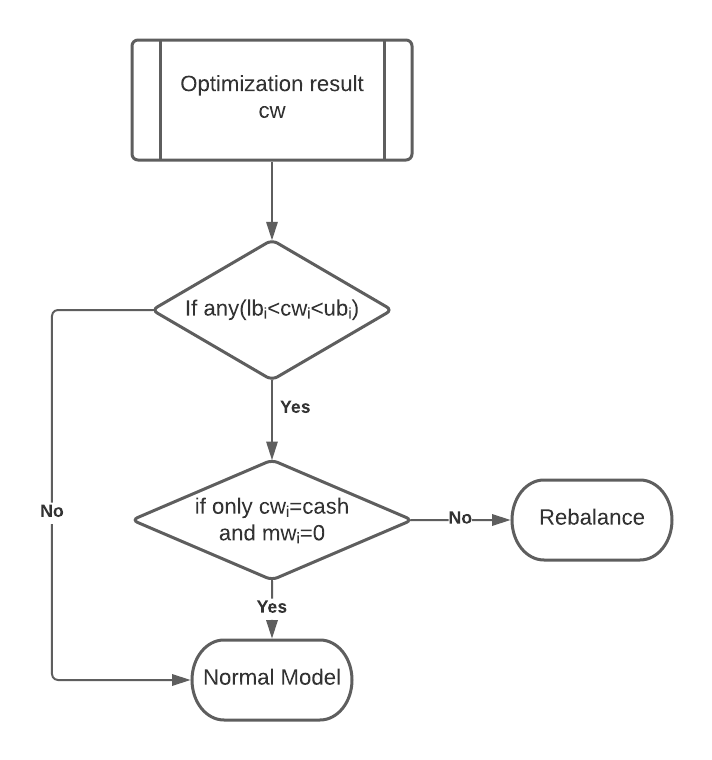

In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
#@title
class stock:
  def __init__(self):
    self.ticker = None
    self.marketprice = None;
    self.value = None;
    self.units = None;
    self.minInitialInvestmentAmt = None;
    self.minTopupAmt = None;
    self.minTopupUnits = None;
    self.weight = None;
    self.contributionFee = None;
    self.minRedemptionAmt = None;
    self.minRedemptionUnits = None;

class portfolio:
  def __init__(self):
    self.ticker = None;
    self.weight = None; # model weight: important
    self.marketprice = None;
    self.minInitialInvestmentAmt = None;

def readStock(ticker):
  tc = stock()
  tc.ticker = ticker['ticker']
  tc.marketprice = float(ticker['marketPrice'])
  tc.units = ticker['units']
  tc.value = float(ticker['value'])
  tc.minTopupUnits = float(ticker['minTopupUnits'])
  tc.minTopupAmt = float(ticker['minTopupAmt'])
  tc.minInitialInvestmentAmt = float(ticker['minInitialInvestmentAmt'])
  tc.contributionFee = float(ticker['contributionFee'])
  tc.minRedemptionAmt = float(ticker['minRedemptionAmt'])
  tc.minRedemptionUnits = float(ticker['minRedemptionUnits'])
  tc.minHoldingAmt = float(ticker['minHoldingAmt'])
  return tc

def readPortfolio(ptfl):
  pf = portfolio()
  pf.ticker = ptfl['ticker']
  pf.marketprice = ptfl['marketPrice']
  pf.weight = ptfl['weight']
  pf.minInitialInvestmentAmt = ptfl['minInitialInvestmentAmt']
  pf.minHoldingAmt = ptfl['minHoldingAmt']

  return pf

def readPtfls(ptfls):
  pt = []
  for i in ptfls:
    pt.append(readPortfolio(i))
  return pt

def readDetail(details):
  tickers = []
  for i in details:
    tickers.append(readStock(i))
  return tickers

def complete(tcs, pfs):
  for j in pfs:
    for i in range(0, len(tcs)):
      if tcs[i].ticker == j.ticker:
        tcs[i].weight = j.weight
  return tcs

In [3]:
input = {
  "amountDecimalPrecision": "2",
  "unitDecimalPrecision": "5",
  "volatilityBuffer": "0.1",
  "goals": [
    {
      "goalId": "123",
      "goalDetails": [
        {
          "ticker": "VTI",
          "units": "5.01636",
          "marketPrice": "141.81",
          "value": "711.37",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "DGRO",
          "units": "17.24309",
          "marketPrice": "35.36",
          "value": "609.72",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IWP",
          "units": "0.49134",
          "marketPrice": "136.75",
          "value": "67.19",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "VWO",
          "units": "1.92159",
          "marketPrice": "34.96",
          "value": "67.18",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IVW",
          "units": "0.36160",
          "marketPrice": "183.70",
          "value": "66.43",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "EFAV",
          "units": "4.45741",
          "marketPrice": "63.51",
          "value": "283.09",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "AGG",
          "units": "2.535",
          "marketPrice": "116.87",
          "value": "296.27",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "MUB",
          "units": "5.04488",
          "marketPrice": "111.57",
          "value": "562.86",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "PNQI",
          "units": "0.00041",
          "marketPrice": "142.05",
          "value": "0.06",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "CASH",
          "units": "75",
          "marketPrice": "1",
          "value": "0",
          "minInitialInvestmentAmt": "0.01",
          "minInitialInvestmentUnits": "0.01",
          "minTopupAmt": "0.01",
          "minTopupUnits": "0.01",
          "minRedemptionAmt": "0.01",
          "minRedemptionUnits": "0.01",
          "minHoldingAmt": "0.01",
          "minHoldingUnits": "0.01",
          "contributionFee": "0"
        }
      ],
      "orderAmount": "100",
      "orderType": "Investment",
      "modelPortfolioId": "MP1",
      "modelPortfolioDetails": [
        {
          "ticker": "VTI",
          "weight": "0.26",
          "marketPrice": "141.81",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "DGRO",
          "weight": "0.22",
          "marketPrice": "35.36",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IWP",
          "weight": "0.03",
          "marketPrice": "136.75",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "VWO",
          "weight": "0.03",
          "marketPrice": "34.96",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "IVW",
          "weight": "0.02",
          "marketPrice": "183.70",
          "value": "66.43",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "EFAV",
          "weight": "0.1",
          "marketPrice": "63.51",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "AGG",
          "weight": "0.11",
          "marketPrice": "116.87",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "MUB",
          "weight": "0.19",
          "marketPrice": "111.57",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "PNQI",
          "weight": "0.04",
          "marketPrice": "142.05",
          "minInitialInvestmentAmt": "5",
          "minInitialInvestmentUnits": "0.00001",
          "minTopupAmt": "5",
          "minTopupUnits": "0.00001",
          "minRedemptionAmt": "5",
          "minRedemptionUnits": "0.00001",
          "minHoldingAmt": "5",
          "minHoldingUnits": "0.00001",
          "contributionFee": "0"
        },
        {
          "ticker": "CASH",
          "weight": "0.00",
          "marketPrice": "1",
          "minInitialInvestmentAmt": "0.01",
          "minInitialInvestmentUnits": "0.01",
          "minTopupAmt": "0.01",
          "minTopupUnits": "0.01",
          "minRedemptionAmt": "0.01",
          "minRedemptionUnits": "0.01",
          "minHoldingAmt": "0.01",
          "minHoldingUnits": "0.01",
          "contributionFee": "0"
        }
      ]
    }
  ]
}

In [4]:
details = input["goals"][0]['goalDetails']
ptfls = input["goals"][0]['modelPortfolioDetails']
orderAmt = float(input["goals"][0]['orderAmount'])

tcs = readDetail(details)
pfs = readPtfls(ptfls)
tcsComp = complete(tcs, pfs)

fund = np.asarray([float(i.value) for i in tcsComp])
fund.sum()
a = [17.73, 9.84,11.89, 11.90, 0.00, 0.54, 10.60, 0.00, 37.50, 0.00] # initial invest
x0 = np.array(a)/(fund.sum()+100) # initial weight
mw = np.asarray([float(i.weight)+np.finfo(np.double).tiny for i in tcsComp])
xn = x0 / mw
# xn.sum()


In [5]:
orderAmt / (np.asarray([float(i.value) for i in tcsComp]).sum() + orderAmt)

0.03617722498977993

In [6]:
#@title
def investOptim(tcsComp, orderAmt, lb=True):
  fund = np.asarray([float(i.value) for i in tcsComp]) #[spy, ivv, ...]
  fundTotal = fund.sum() + orderAmt # total funding after topup
  currWeight = fund / fundTotal # fund = [spy, ivv]
  modelWeight = np.asarray([float(i.weight)+np.finfo(np.double).tiny for i in tcsComp])

  deltaWeight = orderAmt / fundTotal # scalar

  bnds_0 = [(0, None) for i in tcsComp]
  bnds = [(0, None) for i in tcsComp]
  if lb:
    bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp]
  
  x0 = np.ones(len(tcsComp)) * deltaWeight / len(tcsComp)  # initial weight
  # x0 = np.array(a)/fundTotal
  
  cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5
  
  print(deltaWeight)

  result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-20})
  x = result.x
  print(type(x[0]))

  return x, currWeight, modelWeight, (x*fundTotal+ fund) / fundTotal, result, x * fundTotal

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    try:
      np.set_printoptions(precision=3)
      res = []
      tmp = d_cw
      pos = []
      for ind, val in enumerate(d_cw):
        
        if val < bnds[ind][0]/2:         
          tmp[ind] = 0

        elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
          tmp[ind] = bnds[ind][0]

        # d_cw = tmp
        cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5

        result = minimize(obj1, tmp, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds, options={'ftol':1e-20})
        res.append(result.fun)
        pos.append(tmp)

        # print(result.x)
        # d_cw = result.x
      
      # lst = [np.linalg.norm(i-modelWeight) for i in res]
      # print(res)
      d_cw = pos[np.argmin(res)]

    except RecursionError as e:
        print ("something went wrong: " + str(e))

    return np.linalg.norm((currWeight+d_cw-modelWeight))**2 

def obj1(d_cw, currWeight, modelWeight, bnds, dw):
  return np.linalg.norm((currWeight+d_cw-modelWeight))**2

In [12]:
def investOptim(tcsComp, orderAmt, disp=True):

  fund = np.asarray([float(i.value) for i in tcsComp]) 
  fundTotal = fund.sum() + orderAmt 
  currWeight = fund / fundTotal 
  currCopy = currWeight.copy()
  modelWeight = np.asarray([float(i.weight) for i in tcsComp])

  ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
  del_ind = np.array(ind) - np.arange(0, len(ind))
  ins_ind = np.array(ind)   

  deltaWeight = orderAmt / fundTotal 

  bnds_0 = [(0, None) for i in tcsComp if float(i.weight) != 0]

  bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp if float(i.weight) != 0]

  lv = [i[0] for i in bnds] # lower bnd value

  if deltaWeight < np.min(np.array(lv)):
    # if the topup amt is too small, no invest
    if disp:
      print('The topup amt is too small, minTopAmt is', np.min(np.array(lv)*fundTotal))

    dist = np.zeros_like(fund)
    currWeight = fund / np.sum(fund)
    return dist, currWeight, modelWeight, currWeight, dist, fund, True


  else: 

    x0 = np.ones(len(tcsComp)-len(ind)) * deltaWeight / (len(tcsComp) - len(ind)) 
    # print(np.array(lv) * fundTotal)
    # ftol = np.linalg.norm((x0 + currWeight.max() - modelWeight.min()))

    modelWeight = modelWeight.tolist()
    currWeight = currWeight.tolist()
    [modelWeight.pop(i) for i in del_ind]
    [currWeight.pop(i) for i in del_ind]
    
    # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 
    cons = ({'type': 'eq', 'fun': lambda x:  x.sum() * fundTotal - orderAmt}) 
  
    result_invest = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-10, 'disp': disp})
    
    # the condition when optimization result breaks the minTopUp constraints
    if ((np.ones_like(lv) * 1e-3 < result_invest.x) & ( result_invest.x < lv)).any():  
      if disp:
        print(result_invest.x*fundTotal)  
      result_invest = minimize(obj_disj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-3, 'disp': disp})
      
      if not result_invest.success:
        result_invest = minimize(obj_disj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-1, 'disp': disp})

    for i in ins_ind:
      result_invest.x = np.insert(result_invest.x, i, 0)
    result_invest.x = np.asarray([float(i) for i in result_invest.x])

    for i in ins_ind:
      modelWeight = np.insert(modelWeight, i, 0)
      currWeight = np.insert(currWeight, i, currCopy[i])

    return result_invest.x, currWeight, modelWeight, (result_invest.x*fundTotal+fund) / fundTotal, result_invest.x * fundTotal, fund, result_invest.success

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    # with continuous constraints
    return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2

def obj_disj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=4)
    res = []
    i=0
    # print(d_cw)
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      # else:
      #   d_cw[ind] = val

    # return np.linalg.norm((currWeight+d_cw-modelWeight))**2 
    return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2

In [13]:
dist, cw, mw, iw, investAmt, fund, status  = investOptim(tcsComp, 17)
df = pd.DataFrame([dist, cw, mw, iw, investAmt])
df.columns = [i.ticker for i in tcsComp]
df.index = ['invest weight', 'original weight', 'model weight', 'invested weight', 'topup amt']

df.round(5)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.8341645624101945
            Iterations: 9
            Function evaluations: 85
            Gradient evaluations: 5


,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
invest weight,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00634,0.0
original weight,0.26532,0.22741,0.02506,0.02506,0.02478,0.10558,0.1105,0.20993,0.00002,0.0
model weight,0.26000,0.22000,0.03000,0.03000,0.02000,0.10000,0.1100,0.19000,0.04000,0.0
invested weight,0.26532,0.22741,0.02506,0.02506,0.02478,0.10558,0.1105,0.20993,0.00636,0.0
topup amt,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,17.00000,0.0


In [ ]:
np.sum(df.T['topup amt']), np.linalg.norm(df.T['model weight']-df.T['invested weight'])

In [ ]:
np.log(0.017948/0.04)**2, np.log10(0.0116/0.04)**2, np.sum((df.T['topup amt']))

In [ ]:
ab_dis = np.absolute(df.T['invested weight'])
tmp = ab_dis / (df.T['model weight'] + 10e-200)

log_tmp = [np.log10(i)**2 for i in tmp if i < 100]
tmp, log_tmp, np.sum(log_tmp)
# np.linalg.norm(np.log(np.absolute(df.T['model weight'] - df.T['invested weight']))/(df.T['model weight']+10e-20))

In [ ]:
  np.sum(df.T['topup amt']), np.linalg.norm(df.T['model weight']-df.T['invested weight'])

In [ ]:
n=1
print('a',n)

In [26]:
def redempt(tcsComp, orderAmt, disp=True):
  
  fund = np.asarray([float(i.value) for i in tcsComp]) 
  fundTotal = fund.sum() - orderAmt 
  currWeight = fund / fundTotal 
  currCopy = currWeight.copy()
  modelWeight = np.asarray([float(i.weight) for i in tcsComp])

  # index of tickers of modelWeight = 0
  ind = [ind for ind, val in enumerate(modelWeight==0) if val==True] 

  # funding of tickers of mw = 0 in ascending order
  exception_tickers = Sort([[tcsComp[i].value, i] for i in ind])

  # redemption on mw==0 tickers
  easy_redemption, rest_amt = easy_redeem(exception_tickers, orderAmt)

  # index modification corresponding to 0 mw tickers
  del_ind = np.array(ind) - np.arange(0, len(ind)) # delete index
  ins_ind = np.array(ind) # insert index

  deltaWeight = rest_amt / fundTotal 

  bnds_0 = [(0, None) for i in tcsComp if float(i.weight) != 0]
  bnds = [(np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits, i.minHoldingAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, (np.abs(float(i.value)-i.minHoldingAmt)) / fundTotal) for i in tcsComp if float(i.weight) != 0]
  lv = [i[0].round(5) for i in bnds] # lower bnd value
    
  if fundTotal <= np.min(np.array(lv)*fundTotal):
    if disp:
      print('full redemption')
    w_red = fund / fund.sum()
    currWeight = w_red
    amt_red = fund
    return w_red, currWeight, modelWeight, (fund - amt_red) / fundTotal, amt_red, fund, True

  elif orderAmt < np.min(np.array(lv)*fundTotal):
    if disp:
      print('zero redemption. Minimum redeem amount', np.min(np.array(lv)*fundTotal))

    w_red = np.zeros_like(fund)
    amt_red = w_red
    return w_red, currWeight, modelWeight, (fund - amt_red) / fundTotal, amt_red, fund, True

  else:

    x0 = np.ones(len(tcsComp) - len(ind)) * deltaWeight / (len(tcsComp) - len(ind)) 
    modelWeight = modelWeight.tolist()
    currWeight = currWeight.tolist()

    # delete index of tickers with mw 0
    [modelWeight.pop(i) for i in del_ind]
    [currWeight.pop(i) for i in del_ind]
    
    bnd_re = [np.array(i) * fundTotal for i in bnds] # bnds in unit dollar
    
    # cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x * fundTotal) - orderAmt}) 
    cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - deltaWeight}) 

    result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-3, 'disp': disp})

    if ((np.ones_like(lv) * 1e-5 < result.x) & ( result.x < lv)).any():  
      if disp: 
        print(result.x*fundTotal) 
        print('In first round, there is value breaking minRedemption constraint.')
      result = minimize(obj_rdmp, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', 
                      constraints=cons, bounds=bnds_0, options={'ftol':1e-3, 'disp': disp, 'maxiter': 1e3})
      
      if not result.success:        
        result = minimize(obj_rdmp, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', 
                      constraints=cons, bounds=bnds_0, options={'ftol':1e-2, 'disp': disp, 'maxiter': 1e3})

    w_red = result.x
    for i in ins_ind:
      index = exception_tickers[0][:].index(i)
      w_red = np.insert(result.x, i, easy_redemption[0])
      w_red = np.asarray([float(i) for i in w_red])
      modelWeight = np.insert(modelWeight, i, 0)
      currWeight = np.insert(currWeight, i, currCopy[i])

    if disp:
      print(np.sum(result.x))

    amt_red = fundTotal * w_red # redemption amount

    return w_red, currWeight, modelWeight, (fund - amt_red) / fundTotal, amt_red, fund, result.success

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    
    return np.linalg.norm((currWeight-d_cw-modelWeight)/modelWeight)**2

def obj_rdmp(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=3)
    res = []
    i=0

    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      elif val > bnds[ind][1] and val < (bnds[ind][1] + currWeight[ind])/2:
        d_cw[ind] = bnds[ind][1]

      elif val > (bnds[ind][1] + currWeight[ind])/2:
        d_cw[ind] = currWeight[ind]

    # return np.linalg.norm((currWeight-d_cw-modelWeight))
    return np.linalg.norm((currWeight-d_cw-modelWeight)/modelWeight)**2

def Sort(sub_li):  
    # reverse = None (Sorts in Ascending order)
    # key is set to sort using second element of 
    # sublist lambda has been used
    sub_li.sort(key = lambda x: x[0])
    return sub_li

def easy_redeem(nest_list, orderAmt):
  # return the index of tickers and amt except 0 weight ones
  redemption = np.zeros(len(nest_list))
  for ind, val in enumerate(nest_list):
    redemption[ind] = np.min([val[0], orderAmt])
    orderAmt -= np.min([val[0], orderAmt])
    if orderAmt == 0:
      break
  return redemption, orderAmt

In [28]:
dist, cw, mw, rw, redemptAmt, fund, status  = redempt(tcsComp, 550)
df = pd.DataFrame([dist, cw, fund, mw, rw, redemptAmt])
df.columns = [i.ticker for i in tcsComp]
df.index = ['redeemed weight', 'original weight', 'original fund', 'model weight', 'final weight', 'redemption amt']
df.round(5)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0077462188428288
            Iterations: 9
            Function evaluations: 110
            Gradient evaluations: 9
[1.288e+02 1.223e+02 3.587e+00 3.564e+00 2.429e+01 6.634e+01 5.772e+01
 1.435e+02 1.842e-08]
In first round, there is value breaking minRedemption constraint.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0134109042179984
            Iterations: 11
            Function evaluations: 132
            Gradient evaluations: 11
0.2601493730400076


,VTI,DGRO,IWP,VWO,IVW,EFAV,AGG,MUB,PNQI,CASH
redeemed weight,0.06404,0.05847,0.00000,0.00000,0.01129,0.03091,0.02665,0.06879,0.00000,0.0
original weight,0.33648,0.28840,0.03178,0.03178,0.03142,0.13390,0.14014,0.26623,0.00003,0.0
original fund,711.37000,609.72000,67.19000,67.18000,66.43000,283.09000,296.27000,562.86000,0.06000,0.0
model weight,0.26000,0.22000,0.03000,0.03000,0.02000,0.10000,0.11000,0.19000,0.04000,0.0
final weight,0.27244,0.22992,0.03178,0.03178,0.02013,0.10299,0.11348,0.19744,0.00003,0.0
redemption amt,135.38815,123.62136,0.00000,0.00000,23.86400,65.34445,56.34947,145.43257,0.00000,0.0


In [29]:
np.sum(df.T['final weight']), np.sum(df.T['redemption amt']), np.sum(df.T['original fund']), np.sum(df.T['original weight'])

(1.0000000000000033, 549.999999999993, 2664.17, 1.2601493730400108)

In [23]:
relative_loss(mw, rw)

13.620617967139085

In [ ]:
ab_dis = np.absolute(df.T['final weight'])
tmp = ab_dis / (df.T['model weight'] + 10e-200)

log_tmp = [np.log10(i)**2 for i in tmp if i < 100 and i > 0]
print('error is', log_tmp)
print(ab_dis/(df.T['model weight'] + 10e-2))
# np.linalg.norm(np.log(np.absolute(df.T['model weight'] - df.T['invested weight']))/(df.T['model weight']+10e-20))

In [16]:
def relative_loss(mw, rw):
  # calculate the relative distance between model weight and real weight
  # ignore the 0 mw term
  tmp = rw / (mw + 10e-200)
  log_tmp = [np.log10(i)**2 for i in tmp if i < 100 and i > 0]
  return np.sum(log_tmp)

def to_set(x):
  """Convert input int, string, list, tuple, set -> set"""
  if type(x) == set:
    return x
  elif type(x) in [list, set]:
    return set(x)
  elif type(x) in [str, int]:
    return set([x])
  else:
    raise Exception("Unrecognized type.")

def decompose(amt_set, i, thres=0):
  for ind, val in enumerate(list(amt_set)):
    if to_set(i - val).issubset(amt_set) and i - val > thres:
      return val, i-val
      # break

In [14]:
fund = [i.value for i in tcsComp]
iter = int(np.ceil(np.sum(fund)))
lb = [np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits]) for i in tcsComp]
redeem_error = np.zeros(iter)
invest_error = np.zeros(iter)

In [24]:
for i in range(0, iter):
  dist_redeem, cw_redeem, mw, rw, redemptAmt, fund, status_redeem  = redempt(tcsComp, i, disp=False)
  redeem_error[i] = relative_loss(mw, rw)
  if not math.isclose(i, np.sum(redemptAmt), abs_tol=1e0):
    if status_redeem == False:
      print('REDEMPTION ERROR: Input demand ', i, ';   Output amout', np.sum(redemptAmt))

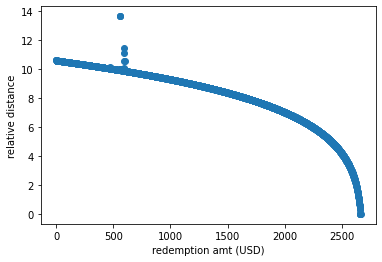

In [25]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter), redeem_error)
plt.xlabel('redemption amt (USD)')
plt.ylabel('relative distance');

In [17]:
for i in range(0, iter):
  dist_invest, cw_invest, mw, iw, investAmt, fund, status_invest  = investOptim(tcsComp, i, disp=False)
  invest_error[i] = relative_loss(mw, iw)
  if not math.isclose(i, np.sum(investAmt), abs_tol=1e0):
    if status_invest == False:
      print('INVESTMENT ERROR: Input demand ', i, ';   Output amout', np.sum(investAmt))

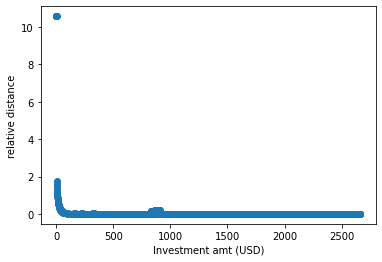

In [18]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter), invest_error)
plt.xlabel('Investment amt (USD)')
plt.ylabel('relative distance');

In [ ]:
fund = [i.value for i in tcsComp]
iter = int(np.ceil(np.sum(fund)))
lb = [np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits]) for i in tcsComp]
redeem_error_decompose = np.zeros(iter)
amt_set = set()
# [print(i.minRedemptionAmt) for i in tcsComp]

for i in range(0, iter):
  amt_set.add(i)
  dist, cw, mw, rw, redemptAmt, fund, status  = redempt(tcsComp, i, disp=False)
  redeem_error_decompose[i] = relative_loss(mw, rw)
  if not math.isclose(i, np.sum(redemptAmt), abs_tol=1e-2):
    amt_set.remove(i)
    if status == False:
      print('REDEMPTION ERROR: Input demand ', i, ';   Output amout', np.sum(redemptAmt))
      amt1, amt2 = decompose(amt_set, i, thres=5)
      # print(amt1, amt2)
      dist, cw, mw1, rw1, redemptAmt1, fund, status  = redempt(tcsComp, amt1, disp=False)
      dist, cw, mw2, rw2, redemptAmt2, fund, status  = redempt(tcsComp, amt2, disp=False)

      # portforlio after two redemption
      pf = fund - (redemptAmt1 + redemptAmt2)
      rw_new = pf/np.sum(pf)
      tmp = relative_loss(mw, rw_new)
      print('the updated value is ', tmp - redeem_error_decompose[i])
      redeem_error_decompose[i] = tmp


In [ ]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter), redeem_error_decompose)
plt.xlabel('redemption amt (USD)')
plt.ylabel('relative distance');

In [ ]:
np.sum(redeem_error), np.sum(redeem_error_decompose)

In [ ]:
redeem_error_dist = np.zeros(iter)
amt_set = set()
# [print(i.minRedemptionAmt) for i in tcsComp]

for i in range(0, iter):
  amt_set.add(i)
  dist, cw, mw, rw, redemptAmt, fund, status  = redempt(tcsComp, i, disp=False)
  redeem_error_dist[i] = relative_loss(mw, rw)
  if not math.isclose(i, np.sum(redemptAmt), abs_tol=1e-2):
    amt_set.remove(i)
    if status == False:
      print('REDEMPTION ERROR: Input demand ', i, ';   Output amout', np.sum(redemptAmt))
      amt1 = max(amt_set)
      # print(amt1, amt2)
      dist, cw, mw1, rw1, redemptAmt1, fund, status  = redempt(tcsComp, amt1, disp=False)
      
      # distributing extra amout uniformly on tickers
      redeem_amt_final = (i-amt1)/len(fund) * np.ones_like(fund) + redemptAmt1

      # portforlio after two redemption
      pf = fund - redeem_amt_final
      rw_new = pf/np.sum(pf)
      tmp = relative_loss(mw, rw_new)
      print('the updated value is ', tmp - redeem_error_dist[i])
      redeem_error_dist[i] = tmp


In [ ]:
# plt.figure(figsize=(8,3))
plt.scatter(np.arange(0, iter), redeem_error_dist)
plt.xlabel('redemption amt (USD)')
plt.ylabel('relative distance');

In [ ]:
plt.plot([*redeem_error_dist[0:400], *redeem_error_dist[700:2500]])

In [ ]:
plt.plot(redeem_error_dist)
plt.plot(redeem_error)

In [ ]:
#@title
def investBalance(tcsComp, orderAmt, thres, cash, lb=True):
  fund = np.asarray([float(i.value) for i in tcsComp]) #[spy, ivv, ...]
  fundTotal = fund.sum() + orderAmt # total funding after topup
  currWeight = fund / fundTotal # fund = [spy, ivv]
  modelWeight = np.asarray([float(i.weight) for i in tcsComp])

  deltaWeight = orderAmt / fundTotal # scalar

  bnds_0 = [(0, None) for i in tcsComp]
  bnds = [(0, None) for i in tcsComp]
  rebalance = False
  if lb:
    bnds = [(np.max([i.minRedemptionAmt, i.marketprice * i.minRedemptionUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp]
  
  # x0 = np.ones(len(tcsComp)) * deltaWeight / len(tcsComp)  # initial weight
  x0 = np.array(a)/fundTotal
  
  cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 

  print(deltaWeight)

  result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-20})

  investedWeight = (result.x*fundTotal+ fund) / fundTotal

  if np.any(investedWeight < modelWeight * (1-thres)) or np.any(investedWeight > modelWeight * (1+thres)):
    ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
    if (len(ind)==1 and tcsComp[ind].tickers == 'Cash' and investedWeight[ind] < cash):
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

      # rebalance
    else:
      rebalance = True
      investAmt = fundTotal * modelWeight
      return rebalance, currWeight, modelWeight, investAmt/investAmt.sum(), investAmt

  else:
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=3)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5

      # result = minimize(obj1, d_cw, args=(currWeight, modelWeight, bnds), method='SLSQP', constraints=cons, bounds=bnds, options={'ftol':1e-20})
      # res.append(result.x)
      # d_cw = result.x    
    return np.linalg.norm((currWeight+d_cw-modelWeight))**2 

def obj1(d_cw, currWeight, modelWeight, bnds):
  return np.linalg.norm((currWeight+d_cw-modelWeight))**2

In [ ]:
#@title
def investBalanceNormal(tcsComp, orderAmt, thres, cash, lb=True):
  fund = np.asarray([float(i.value) for i in tcsComp]) #[spy, ivv, ...]
  fundTotal = fund.sum() + orderAmt # total funding after topup
  currWeight = fund / fundTotal # fund = [spy, ivv]
  modelWeight = np.asarray([float(i.weight)+np.finfo(np.double).tiny for i in tcsComp])

  deltaWeight = orderAmt / fundTotal # scalar

  bnds_0 = [(0, None) for i in tcsComp]
  bnds = [(0, None) for i in tcsComp]
  rebalance = False
  if lb:
    bnds = [(np.max([i.minTopupAmt, i.marketprice * i.minTopupUnits, i.minInitialInvestmentAmt * (i.value==0)]) 
    * (1+i.contributionFee) / fundTotal, None) for i in tcsComp]
  
  # x0 = np.ones(len(tcsComp)) * deltaWeight / len(tcsComp)  # initial weight
  x0 = np.array(a)/fundTotal
  
  cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) 

  print(deltaWeight)

  result = minimize(obj, x0, args=(currWeight, modelWeight, bnds, deltaWeight), method='SLSQP', constraints=cons, bounds=bnds_0, options={'ftol':1e-20})

  investedWeight = (result.x*fundTotal+ fund) / fundTotal

  if np.any(result.x+currWeight/modelWeight < (1-thres)) or np.any(result.x+currWeight/modelWeight  > (1+thres)):
    ind = [ind for ind, val in enumerate(modelWeight==0) if val==True]
    print(ind, len(ind))
    if (len(ind)==1 and tcsComp[ind[0]].ticker == 'Cash' and result.x+currWeight/modelWeight < cash):
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

      # rebalance
    else:
      rebalance = True
      investAmt = fundTotal * modelWeight
      print(fundTotal, investAmt)
      return rebalance, currWeight, modelWeight, investAmt/investAmt.sum(), investAmt-fund

  else:
      return result.x, currWeight, modelWeight, (result.x*fundTotal+ fund) / fundTotal, result.x * fundTotal

def obj(d_cw, currWeight, modelWeight, bnds, deltaWeight):
    np.set_printoptions(precision=3)
    res = []
    i=0
    for ind, val in enumerate(d_cw):
      i+=1
      if val < bnds[ind][0]/2:         
        d_cw[ind] = 0

      elif val > bnds[ind][0]/2 and val < bnds[ind][0]:
        d_cw[ind] = bnds[ind][0]

      # cons = ({'type': 'eq', 'fun': lambda x:  x.sum() - deltaWeight}) # x >= b; b in {0,1} x=0.5

      # result = minimize(obj1, d_cw, args=(currWeight, modelWeight, bnds), method='SLSQP', constraints=cons, bounds=bnds, options={'ftol':1e-20})
      # res.append(result.x)
      # d_cw = result.x    
    return np.linalg.norm((currWeight+d_cw-modelWeight)/modelWeight)**2 

def obj1(d_cw, currWeight, modelWeight, bnds):
  return np.linalg.norm((currWeight+d_cw-modelWeight))**2

In [ ]:
#@title
thres = np.random.rand(len(tcsComp))/4  # random threshold
# thres = np.zeros(len(tcsComp))+0.5; 
thres

In [ ]:
#@title
dist, cw, mw, iw, investAmt  = investBalanceNormal(tcsComp, orderAmt, thres, 0.02)
if type(dist)==bool:
  df = pd.DataFrame([mw * (1-thres), cw, mw * (1+thres), mw, iw, investAmt])
  df.columns = [i.ticker for i in tcsComp]
  df.index = ['lower bound', 'original weight', 'upper bound', 'model weight', 'invested weight', 'topup amt']
  df.loc['threshold'] = thres
  # df.loc['lower bound'] = mw * (1-thres)
  # df.loc['upper bound'] = mw * (1+thres)
  print("Rebalanced")
else:
  df = pd.DataFrame([dist, cw, mw, iw, investAmt])
  df.columns = [i.ticker for i in tcsComp]
  df.index = ['invest weight', 'original weight', 'model weight', 'invested weight', 'topup amt']
  df.loc['threshold'] = thres
  df

df